In [1]:
import numpy as np
import pandas as pd
import pygmo as pg
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 500)

from sklearn.externals import joblib 
from config import MAX_DISCOUNT, FEATURES

%matplotlib inline
%load_ext line_profiler

In [2]:
df=pd.read_csv('training_data_randn.csv', nrows=50000)
cols_x = FEATURES
col_y = 'is_deal'
col_p = 'Probability'
print(df.shape)

(50000, 22)


In [3]:
model = joblib.load('propensity_model_sklearn_mlp.pkl')

In [4]:
%%timeit
model.predict_proba(df[cols_x])

29.7 ms ± 5.44 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [5]:
df.loc[:, 'pred'] = model.predict_proba(df[cols_x])[:,1]

# Background

Linear programming vs non-linear programming

Optimization algorithms: local vs heuristic

# User Defined Problem (UDP)

## Objectives

In [6]:
v_space = 0.01
f_discounts = np.arange(0, MAX_DISCOUNT + v_space, v_space)

cols_grpby = ['product_id']

scan_propensity = []
scan_revenue = []
scan_profit = []

for f in f_discounts:
    X = df[cols_x].values
    X[:, -1] = df['RRP']*f 
    col_discount = 'Discount_{:.02f}'.format(f)
    col_pred = 'y_pred_{:.02f}'.format(f)
    df.loc[:, col_discount] = X[:, -1]
    df.loc[:, col_pred] = model.predict_proba(X)[:, 1]
    
    # Prospensity
    s_prop = df.groupby(cols_grpby).apply(lambda df: np.mean(df[col_pred])).rename(f)
    s_reve = df.groupby(cols_grpby).apply(lambda df: np.dot(df['RRP'] - df[col_discount], df[col_pred])).rename(f)
    s_prof = df.groupby(cols_grpby).apply(lambda df: np.dot(df['RRP'] - df[col_discount] - df['Cost'], df[col_pred])).rename(f)

    scan_propensity.append(s_prop)
    scan_revenue.append(s_reve)
    scan_profit.append(s_prof)

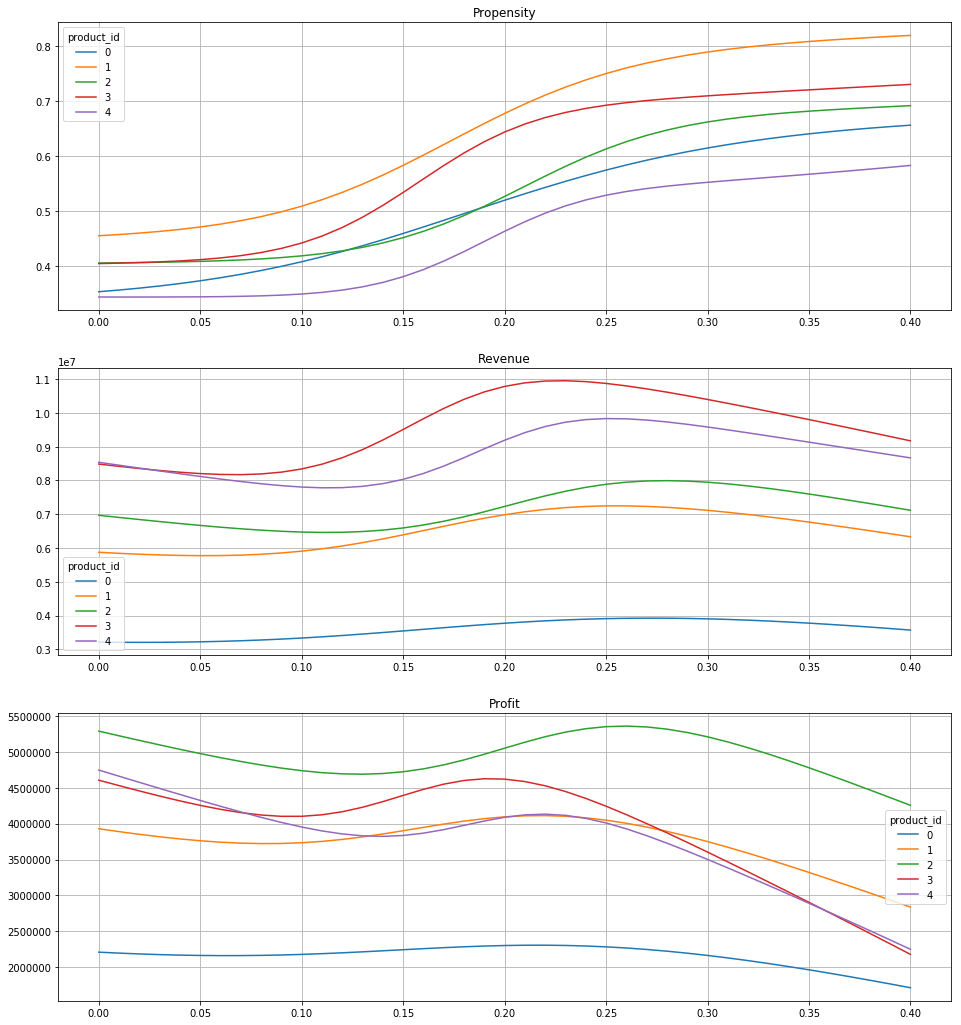

In [7]:
f, ax = plt.subplots(3, 1, figsize=(16,18))
pd.concat(scan_propensity, axis=1).T.plot(ax = ax[0],  title='Propensity', grid=True)
pd.concat(scan_revenue, axis=1).T.plot(ax = ax[1],  title='Revenue', grid=True)
pd.concat(scan_profit, axis=1).T.plot(ax = ax[2],  title='Profit', grid=True)

## Single-objective optimization

Find out the discount amount for each product in order to maximize revenue

In [8]:
class optimal_discount_per_product_for_max_profit:
    def __init__(self, df, model): 
        self.cols_x = FEATURES
        self.df = df     
        self.p_ids = df['product_id'].unique()
        self.p_ids.sort()
        self.n_products = len(self.p_ids)
        self.model = model
        
    def fitness(self, dv): # fitness given decision vector (dv)
        prod_discount = dict(zip(self.p_ids, dv))
        v_dis = self.df['product_id'].map(prod_discount) * self.df['RRP']
        X = self.df[self.cols_x].values
        X[:, -1] = v_dis
        y_prob = self.model.predict_proba(X)[:, 1]
        profit = np.dot(self.df['RRP'] - v_dis - self.df['Cost'], y_prob)  
        return [-profit/1e6,]   

    def get_bounds(self): # box bounds of decision vector (dv)
        return ([0,]*self.n_products, [MAX_DISCOUNT, ]*self.n_products)

Notes:
* PyGMO2 assume minimization in every objective
* Default assume single-objective, all continuous decision vectors
* Return of fitness() must be a list, even for single-objective problems

In [9]:
pp_profit = optimal_discount_per_product_for_max_profit(df, m)

In [10]:
prob = pg.problem(pp_profit)
algo = pg.algorithm(pg.de(gen = 50))
pop = pg.population(prob,10)
algo.set_verbosity(2)

In [11]:
pop = algo.evolve(pop)

In [12]:
best_x_rev = pop.champion_x
best_f_rev = pop.champion_f
print(best_x_rev, best_f_rev) 

[0.23160705 0.23571408 0.26578473 0.19634883 0.00491881] [-21.07476116]


In [13]:
log = algo.extract(pg.de).get_log()

In [14]:
log

[(1, 10, -20.259485860115834, 0.4256869441171946, 2.46018659247666),
 (3, 30, -20.259485860115834, 0.5078613518349223, 1.2788833805833129),
 (5, 50, -20.259485860115834, 0.6165170706650299, 1.2529309909428825),
 (7, 70, -20.259485860115834, 0.22053344340755296, 0.818797852354038),
 (9, 90, -20.688849080861473, 0.2999569867866632, 0.7038014984875964),
 (11, 110, -20.688849080861473, 0.4485937834711125, 0.7008327157182777),
 (13, 130, -20.705898230769783, 0.21893230493396293, 0.6676851085897759),
 (15, 150, -20.787421223634475, 0.22850847448001577, 0.7492081014544674),
 (17, 170, -20.787421223634475, 0.22850847448001577, 0.7492081014544674),
 (19, 190, -20.836670551620216, 0.27105744828725464, 0.7984574294402087),
 (21, 210, -20.836670551620216, 0.2853949888041363, 0.6241638568980612),
 (23, 230, -20.836670551620216, 0.27049432623082664, 0.5382509810571605),
 (25, 250, -20.84138247001368, 0.1808812679538714, 0.5429628994506253),
 (27, 270, -20.84138247001368, 0.1808812679538714, 0.542962

## Multi-objective optimization

In [15]:
class optimal_discount_per_product_for_max_revenue_min_cost:
    def __init__(self, df, model): 
        self.cols_x = FEATURES
        self.df = df
        self.p_ids = df['product_id'].unique()
        self.p_ids.sort()
        self.n_products = len(self.p_ids)
        self.model = model        
   
    def get_nobj(self):
        return 2
    
    def fitness(self, dv): # fitness given decision vector (dv)
        prod_discount = dict(zip(self.p_ids, dv))
        v_dis = self.df['product_id'].map(prod_discount) * self.df['RRP']
        X = self.df[self.cols_x].values
        X[:, -1] = v_dis
        y_prob = self.model.predict_proba(X)[:, 1]
        revenue = np.dot(self.df['RRP'] - v_dis, y_prob)  
        cost = np.dot(self.df['Cost'], y_prob)  
        return [-revenue/1e6,cost/1e6]   # Minimization objectives
    
    def get_bounds(self): # box bounds of decision vector (dv)       
        return ([0,]*self.n_products, [MAX_DISCOUNT, ]*self.n_products)

In [16]:
pp_rev_cost = optimal_discount_per_product_for_max_revenue_min_cost(df, m)

In [42]:
prob = pg.problem(pp_rev_cost)
pop = pg.population(prob,64)

In [43]:
algo = pg.algorithm(pg.nsga2(gen = 1))
# algo.set_verbosity(1)

In [ ]:
refpoint = [ -30, 30]
log_pop = []
hv = pg.hypervolume(pop).compute(refpoint)
log_pop.append((pop.get_x(), pop.get_f(), hv))
print(hv)
for i in range(129):
    pop = algo.evolve(pop)
    hv = pg.hypervolume(pop).compute(refpoint)
    log_pop.append((pop.get_x(), pop.get_f(), hv))
    if np.log2(i+1).is_integer():
        print(i, hv)


137.46807575200017
0 139.99874700638594
1 142.29737627206964
3 144.89144069994288
7 148.14052043345777
15 150.21642408025946
31 151.29366167454327


In [ ]:
fits, vectors = -pop.get_f(), pop.get_x()
ndf, dl, dc, ndr = pg.fast_non_dominated_sorting(fits)

In [ ]:
idx_sorted = fits.argsort(0)[:, 0]

In [ ]:
for id in idx_sorted:
    print(fits[id], vectors[id].round(3))

In [ ]:
def plot_pareto_frontiers(fs, **kwarg):
    df = pd.DataFrame(fs, columns = ('Revenue', 'Cost')).sort_values('Revenue')   
    df.loc[:, 'pareto_group'] = pg.fast_non_dominated_sorting(df.values)[3]
    df['Revenue'] = -df['Revenue']
    df.groupby('pareto_group').plot('Revenue', 'Cost', style='o-', legend=False, **kwarg, ax=plt.gca())
    plt.gca().set_ylabel('Cost')
    return
   
x_max = np.array([pop[1] for pop in log_pop])[:,:, 0].max()+1
x_min = np.array([pop[1] for pop in log_pop])[:,:, 0].min()-1
y_max = np.array([pop[1] for pop in log_pop])[:,:, 1].max()+1
y_min = np.array([pop[1] for pop in log_pop])[:,:, 1].min()-1
axis_range = ((x_min, x_max), (y_min, y_max))
for i, (dvs, fs, hv) in enumerate(log_pop):
    if np.log2(i+1).is_integer():
        plt.cla()
        ax = plot_pareto_frontiers(fs, xlim=(-x_max, -x_min), ylim=(y_min, y_max), figsize=(8,6), title='Evolution %d'%(i+1)) 
        plt.savefig('test_%d.png'%(np.log2(i+1)))


## Hypervolume

* Reference point
* For dimensionality>1 only


## Decorator meta-problem
https://esa.github.io/pagmo2/docs/python/tutorials/udp_meta_decorator.html


In [ ]:
??m.model._make_predict_function

## Parallelization

Island

Run evolutions on 
* multi-threading
* multi-processing
* cluster

Archipelago


Keras: 
model._make_predict_function 
https://stackoverflow.com/questions/40850089/is-keras-thread-safe

In [ ]:
algo = pg.algorithm(pg.nsga2(gen = 1))
prob = pg.problem(pp_rev_cost)
pop = pg.population(prob,16)

In [ ]:
isl_0 = pg.island(algo = pg.de(10), prob = pg.ackley(5), size=20, udi=pg.thread_island())

## Optimization with constraint

## Integer problem

## Optimization with gradient/hessian

## Logging during training

log = algo.extract(pg.nlopt).get_log()
from matplotlib import pyplot as plt 
plt.semilogy([line[0] for line in log], [line[1] for line in log], label = "obj") 
plt.semilogy([line[0] for line in log], [line[3] for line in log], label = "con")
